In [90]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
plt.style.use('seaborn')
torch.manual_seed(2019)

In [91]:
transform = transforms.Compose([transforms.Resize((28,28)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,))
                               ])

In [124]:
training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=100, shuffle=False)

In [93]:
# transform = transforms.Compose([transforms.Resize((28,28)),
#                                transforms.ToTensor(),
#                                transforms.Normalize((0.5,), (0.5,))
#                                ])
# training_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# validation_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=100, shuffle=True)
# validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = 100, shuffle=False)

In [94]:
training_dataset

Dataset MNIST
    Number of datapoints: 60000
    Split: train
    Root Location: ./data
    Transforms (if any): Compose(
                             Resize(size=(28, 28), interpolation=PIL.Image.BILINEAR)
                             ToTensor()
                             Normalize(mean=(0.5,), std=(0.5,))
                         )
    Target Transforms (if any): None

In [95]:
#convert from tensor to numpy
def im_convert(tensor):
    image = tensor.clone().detach().numpy() # (1,28,28)
    image = image.transpose(1, 2, 0) # (28,28,1)
    image = image * np.array((.5, .5, .5)) + np.array((.5, .5, .5)) #denormalize
    image = image.clip(0, 1)
    return image

In [96]:
dataiter = iter(training_loader)
images, labels = dataiter.next()

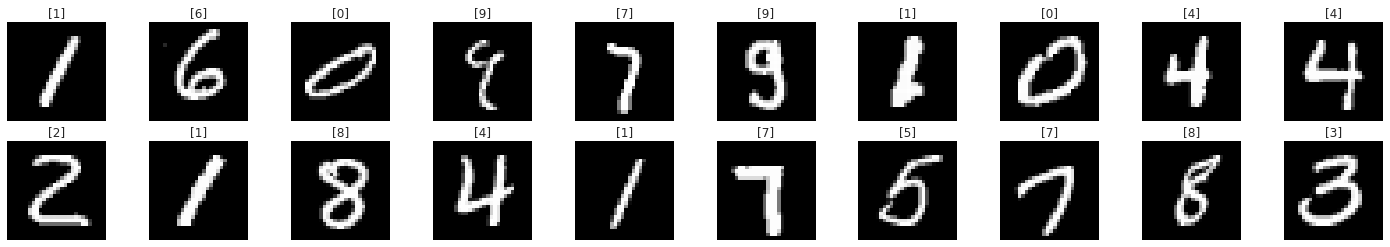

In [97]:
#Plot some images
fig = plt.figure(figsize=(25, 4))

for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title([labels[idx].item()])

In [128]:
class ClassifierModel(nn.Module):
    def __init__(self, input_size, hidden_layer1_size, hidden_layer2_size, output_size):
        super().__init__()
        self.linear1 = nn.Linear(input_size, hidden_layer1_size)
        self.linear2 = nn.Linear(hidden_layer1_size, hidden_layer2_size)
        self.linear3 = nn.Linear(hidden_layer2_size, output_size)
        
    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [129]:
model = ClassifierModel(28*28, 125, 65, 10)
model

ClassifierModel(
  (linear1): Linear(in_features=784, out_features=125, bias=True)
  (linear2): Linear(in_features=125, out_features=65, bias=True)
  (linear3): Linear(in_features=65, out_features=10, bias=True)
)

In [130]:
criterion = nn.CrossEntropyLoss() # used for multiclass classification
optmizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [131]:
epochs = 20
running_loss_history = []
running_correct_history = []
val_running_loss_history = []
val_running_correct_history = []

for epoch in range(epochs):
    #each training batch
    running_loss = 0.0
    running_corrects = 0.0
    val_running_loss = 0.0
    val_running_corrects = 0.0
    
    for inputs, labels in training_loader:
        #flat it 1, 784
        inputs = inputs.view(inputs.shape[0], -1)
        outputs = model(inputs) # return proba for each class (score)
        loss = criterion(outputs, labels)
        
        optmizer.zero_grad()
        loss.backward()
        optmizer.step()
        
        #max score output class
        _, preds = torch.max(outputs, 1)
        
        running_loss += loss.item()
        #number of correct predictions
        running_corrects += torch.sum(preds == labels.data)
        
        
    else:
        #execute once loop end
        
        with torch.no_grad(): #set all the grad flags to false to get better perfomance
            for val_inputs, val_labels in validation_loader:
                val_inputs = val_inputs.view(val_inputs.shape[0], -1)
                val_outputs = model(val_inputs) # return proba for each class (score)
                val_loss = criterion(val_outputs, val_labels)
                
                #max score output class
                _, val_preds = torch.max(val_outputs, 1)

                val_running_loss += val_loss.item()
                #number of correct predictions
                val_running_corrects += torch.sum(val_preds == val_labels.data)


            epoch_loss = running_loss/len(training_loader)#n of batches
            epoch_acc = running_corrects.float()/len(training_loader)
            running_loss_history.append(epoch_loss)
            running_correct_history.append(epoch_acc)
            
            val_epoch_loss = val_running_loss/len(validation_loader)#n of batches
            val_epoch_acc = val_running_corrects.float()/len(validation_loader)
            val_running_loss_history.append(val_epoch_loss)
            val_running_correct_history.append(val_epoch_acc)
            print('Epoch ', epoch + 1)
            print('training loss: {:.4f} - training acc: {:.4f} | validation loss: {:.4f} - val acc: {:.4f}'.format(
                epoch_loss, epoch_acc.item(), val_epoch_loss, val_epoch_acc.item()))

Epoch  1
training loss: 0.9195 - training acc: 78.2917 | validation loss: 0.4110 - val acc: 89.1300
Epoch  2
training loss: 0.3674 - training acc: 89.6067 | validation loss: 0.3076 - val acc: 91.0700
Epoch  3
training loss: 0.3047 - training acc: 91.2167 | validation loss: 0.2810 - val acc: 91.9300
Epoch  4
training loss: 0.2711 - training acc: 92.1800 | validation loss: 0.2472 - val acc: 92.9300
Epoch  5
training loss: 0.2456 - training acc: 92.8800 | validation loss: 0.2243 - val acc: 93.5000
Epoch  6
training loss: 0.2253 - training acc: 93.5167 | validation loss: 0.2102 - val acc: 93.9900
Epoch  7
training loss: 0.2067 - training acc: 94.0800 | validation loss: 0.1951 - val acc: 94.3300
Epoch  8
training loss: 0.1911 - training acc: 94.5117 | validation loss: 0.1846 - val acc: 94.7100
Epoch  9
training loss: 0.1779 - training acc: 94.8817 | validation loss: 0.1709 - val acc: 94.9800
Epoch  10
training loss: 0.1647 - training acc: 95.2650 | validation loss: 0.1578 - val acc: 95.3500

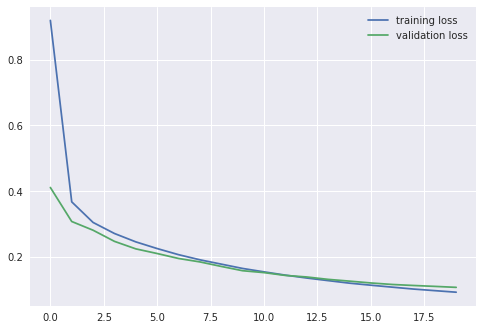

In [132]:
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

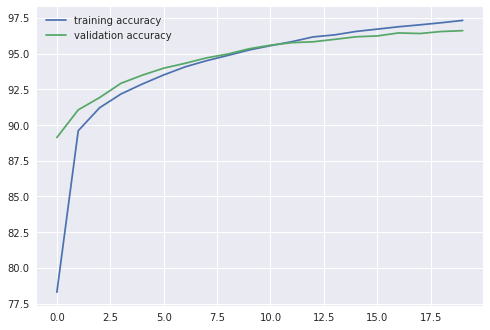

In [133]:
plt.plot(running_correct_history, label='training accuracy')
plt.plot(val_running_correct_history, label='validation accuracy')
plt.legend()

# test random images

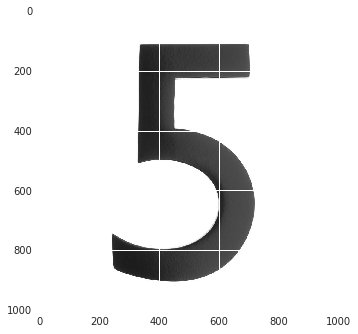

In [134]:
import PIL.ImageOps
import requests
from PIL import Image

url = 'https://images.homedepot-static.com/productImages/007164ea-d47e-4f66-8d8c-fd9f621984a2/svn/architectural-mailboxes-house-letters-numbers-3585b-5-64_1000.jpg'
response = requests.get(url, stream = True)
img = Image.open(response.raw)
plt.imshow(img)

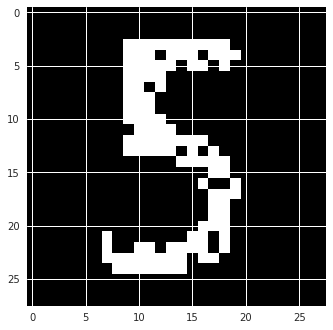

In [135]:
#Preprocessing
img = PIL.ImageOps.invert(img)
img = img.convert('1')
img = transform(img) 
plt.imshow(im_convert(img))

In [139]:
#predict
img = img.view(img.shape[0], -1)
output = model(img)
_, pred = torch.max(output, 1)
print(output)
print("Prediction: ", pred.item())

tensor([[-5.5522, -0.6249, -3.8572,  7.6704, -4.7249, 11.4295, -4.7546, -7.6103,
          1.9627, -1.8294]], grad_fn=<AddmmBackward>)
Prediction:  5


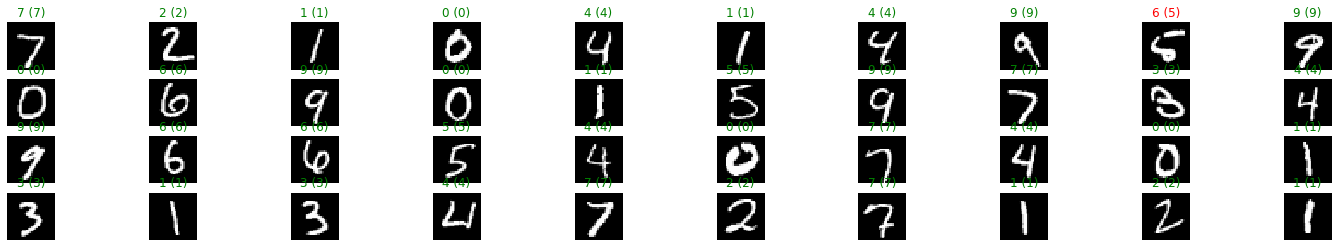

In [142]:
#predict all vals and print 20
dataiter = iter(validation_loader)
images, labels = dataiter.next()
images_ = images.view(images.shape[0], -1)
output = model(images_)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25, 4))

for idx in np.arange(40):
    ax = fig.add_subplot(4, 10, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title("{} ({})".format(str(preds[idx].item()), 
                                  str(labels[idx].item())), 
                 color=("green" if preds[idx]==labels[idx] else "red"))

## example of too large learning rate, the gradient descent overshoot the minima: lr = 0.01

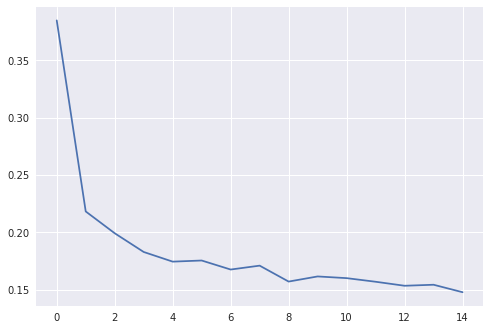

In [102]:
plt.plot(running_loss_history, label='training loss')